<!-- # 학습 개선방향
### 데이터 
- `04_014_FE.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
    - date_block_num >= 12 로 데이터 고정
    - test 데이터에 존재하는 item_id로 데이터 필터링
    - item_name에 대한 파생 피처 생성
### 학습
- 학습 결과 평가
    - 모델의 예측값과 타겟값을 직접 비교
    - 예측값과 타겟값의 차이가 큰 데이터를 직접 확인
    - 검증(10월) 데이터에 대한 예측값의 평균보다 테스트(11월) 데이터에 대한 예측값의 평균이 낮아야 함. 데이터를 통해 11월의 매출이 1년 중 가장 낮은 것을 확인 -->

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb

%matplotlib inline
plt.style.use("seaborn-v0_8-white")
pd.options.display.float_format = '{:.6f}'.format

 # Data

In [2]:
data_path = "./data/"

# old_one = joblib.load(data_path + 'all_data2.joblib')
all_data = joblib.load(data_path + 'all_data_result.joblib')
test = pd.read_csv(data_path + 'test.csv')
all_data.shape, test.shape

((8812167, 38), (214200, 3))

In [3]:
print(all_data.duplicated(subset=['date_block_num', 'shop_id', 'item_id']).sum())
print(all_data['date_block_num'].min())

0
0


In [4]:
temp = all_data.isna().sum()
print(temp[temp > 0])
del temp

date_item_avg_price_lag_1    2027634
rolling_3m_price_mean        1194831
dtype: int64


In [5]:
sorted(all_data.columns.tolist())

['category_nov_ratio',
 'city',
 'city_item_avg_date_sales_lag_1',
 'date_block_num',
 'date_item_avg_price_lag_1',
 'delta_price_lag',
 'item_age',
 'item_avg_date_sales_diff_1',
 'item_avg_date_sales_diff_2',
 'item_avg_date_sales_lag_1',
 'item_avg_date_sales_lag_2',
 'item_category_avg_date_sales_lag_1',
 'item_category_avg_date_sales_lag_2',
 'item_category_id',
 'item_cnt_month',
 'item_cnt_month_diff_1',
 'item_cnt_month_diff_2',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_id',
 'item_shop_age',
 'item_shop_last_sale',
 'meta',
 'month',
 'new_item_effect',
 'platform',
 'rolling_3m_cnt_mean',
 'rolling_3m_cnt_std',
 'rolling_3m_item_cat_mean',
 'rolling_3m_item_mean',
 'rolling_3m_item_std',
 'rolling_3m_price_mean',
 'shop_id',
 'shop_item_category_avg_date_sales_lag_1',
 'transaction_cnt_lag_1',
 'transaction_cnt_lag_2',
 'type_code']

# Model

## Validation

In [6]:
cat_features = ['shop_id', 'item_category_id', 'city', 'type_code', 'platform', 'month', 'meta']

for col in cat_features:
    all_data[col] = all_data[col].astype('category')

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8812167 entries, 0 to 8812166
Data columns (total 38 columns):
 #   Column                                   Dtype   
---  ------                                   -----   
 0   shop_id                                  category
 1   item_id                                  int16   
 2   date_block_num                           int8    
 3   item_cnt_month                           int8    
 4   city                                     category
 5   item_category_id                         category
 6   platform                                 category
 7   meta                                     category
 8   type_code                                category
 9   month                                    category
 10  shop_item_category_avg_date_sales_lag_1  float32 
 11  city_item_avg_date_sales_lag_1           float32 
 12  transaction_cnt_lag_1                    int8    
 13  date_item_avg_price_lag_1                float64 
 14  it

In [80]:
%%time
drop_cols = ['item_cnt_month', 'item_avg_date_sales_lag_1', 'item_category_avg_date_sales_lag_2', 'item_cnt_month_diff_1', 'item_cnt_month_diff_2', \
    'rolling_3m_item_std', 'rolling_3m_cnt_std'] # 
val_month = 33

train_mask = all_data['date_block_num'] < val_month
x_train = all_data.loc[train_mask].drop(drop_cols, axis=1)

val_mask = all_data['date_block_num'] == val_month
x_val = all_data.loc[val_mask].drop(drop_cols, axis=1)

y_train = all_data.loc[train_mask, 'item_cnt_month'].clip(0, 20)
y_val = all_data.loc[val_mask, 'item_cnt_month'].clip(0, 20)

test_mask = all_data['date_block_num'] == 34
x_test = all_data.loc[test_mask].drop(drop_cols, axis=1)

print(f'학습데이터 : {x_train.shape}')

cat_features = ['shop_id', 'item_category_id', 'city', \
    'type_code', 'platform', 'month', 'meta', ] #  

# best_params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'random_state': 42,
#     'eta': 0.01,
#     'colsample_bytree' : 0.7, # 0.6618
#     'subsample': 0.8, # 0.6289
#     'alpha': 0.1, 
#     'lambda': 1.0, 
#     'min_child_weight' : 1, # 30 - 5 
#     'gamma': 0.0,
#     'max_depth' : 10, # 8
#     'device': 'cuda',
#     'tree_method': 'hist',
# }

best_params = {
    'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'random_state': 42,
    'max_delta_step': 0.7,
    'eta': 0.01,
    'colsample_bytree' : 0.7, # 0.6618
    'subsample': 0.7, # 0.6289 - 0.8
    'alpha': 0.5, # 0.1 - 
    'lambda': 1.0, 
    'min_child_weight' : 3, # 30 - 5 
    'gamma': 0.0,
    'max_depth' : 10, # 8
    'device': 'cuda',
    'tree_method': 'hist',
}

# best_params = {
#     'objective': 'reg:tweedie',
#     'tweedie_variance_power': 1.1, # 1.0654
#     'eval_metric': 'rmse',
#     'random_state': 42,
#     'eta': 0.01,
#     'colsample_bytree' : 0.6618, # 0.6618
#     'subsample': 0.6289, # 0.6289
#     'alpha': 0.1, 
#     'lambda': 1.0, 
#     'min_child_weight' : 30, # 20
#     'gamma': 0.1,
#     'max_depth' : 8,
#     'device': 'cuda',
#     'tree_method': 'hist',
# }


dtrain_xgb = xgb.DMatrix(x_train, y_train, enable_categorical=True)
dval_xgb = xgb.DMatrix(x_val, y_val, enable_categorical=True)
dtest_xgb = xgb.DMatrix(x_test, enable_categorical=True)

evals = [(dtrain_xgb, 'train'), (dval_xgb, 'eval')]
evals_result = {}

xgb_model = xgb.train(
    params=best_params,
    dtrain=dtrain_xgb,
    num_boost_round=10000,
    evals=evals,
    verbose_eval=100,
    early_stopping_rounds=300,
    evals_result=evals_result
)

학습데이터 : (8376165, 31)
[0]	train-rmse:1.24173	eval-rmse:1.08007
[100]	train-rmse:1.19164	eval-rmse:1.03446
[200]	train-rmse:1.12921	eval-rmse:0.98345
[300]	train-rmse:1.05061	eval-rmse:0.92400
[400]	train-rmse:0.96414	eval-rmse:0.86579
[500]	train-rmse:0.88958	eval-rmse:0.82024
[600]	train-rmse:0.84707	eval-rmse:0.79972
[700]	train-rmse:0.82242	eval-rmse:0.79192
[800]	train-rmse:0.80657	eval-rmse:0.78802
[900]	train-rmse:0.79509	eval-rmse:0.78618
[1000]	train-rmse:0.78655	eval-rmse:0.78473
[1100]	train-rmse:0.77954	eval-rmse:0.78395
[1200]	train-rmse:0.77394	eval-rmse:0.78383
[1300]	train-rmse:0.76885	eval-rmse:0.78291
[1400]	train-rmse:0.76390	eval-rmse:0.78218
[1500]	train-rmse:0.75906	eval-rmse:0.78241
[1600]	train-rmse:0.75455	eval-rmse:0.78197
[1700]	train-rmse:0.75032	eval-rmse:0.78201
[1800]	train-rmse:0.74583	eval-rmse:0.78190
[1900]	train-rmse:0.74171	eval-rmse:0.78145
[2000]	train-rmse:0.73755	eval-rmse:0.78128
[2100]	train-rmse:0.73386	eval-rmse:0.78160
[2200]	train-rmse:0.73

In [ ]:
# [2096]	train-rmse:0.76231	eval-rmse:0.77930 | LB : 0.86639, tweedie=1.1, min=30 +++++++++++++++++

### diff, std 삭제, reg:squarederror###################################################################
# [1200]	train-rmse:0.81166	eval-rmse:0.78404 | LB : 0.88969, 
### 규제완화 : min=5
# [1287]	train-rmse:0.73433	eval-rmse:0.78692 | LB : 0.87371
### 규제완화 : min=1
# [900]	train-rmse:0.74747	eval-rmse:0.78476 | LB : 0.88252
### poisson
# [2388]	train-rmse:0.72111	eval-rmse:0.78070 | LB : 0.86745
### min=3, alpha=0.5, subsample=0.7
# [2376]	train-rmse:0.72400	eval-rmse:0.78123 | LB : 0.86598 **************************************


In [82]:
print('Best score: ', xgb_model.best_score)
print('Best iteration: ', xgb_model.best_iteration)

Best score:  0.7812069390642485
Best iteration:  2077


> LB : 0.86639

In [83]:
val_preds = xgb_model.predict(dval_xgb, iteration_range=(0, xgb_model.best_iteration + 1)).clip(0, 20)
print(f'CV Prediction Mean  :{val_preds.mean()}')
print(f'Validation Mean     :{y_val.mean()}')
print(len(val_preds[val_preds < 0.3]) / len(val_preds))
print(len(y_val[y_val < 0.3]) / len(y_val))

CV Prediction Mean  :0.25018951296806335
Validation Mean     :0.2576667478201279
0.8175985789127239
0.8616108060342107


## Learning Curve

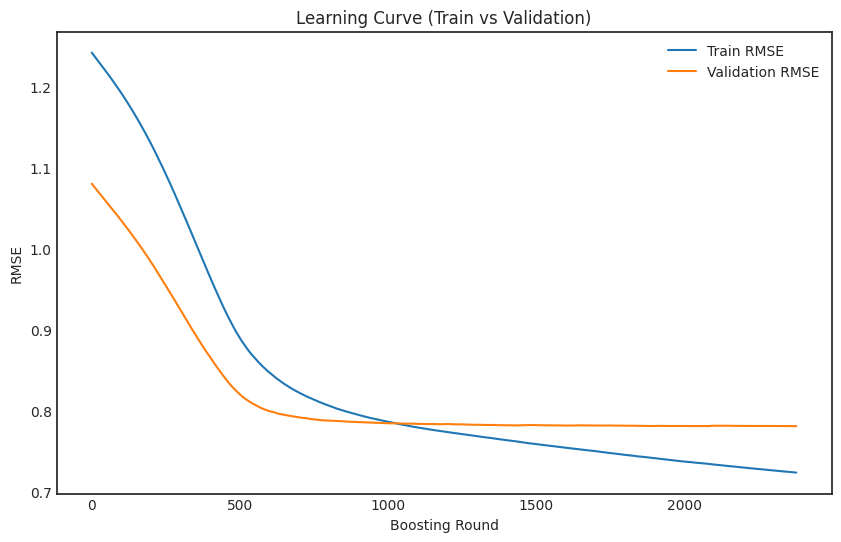

In [84]:
metric = 'rmse' 
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

train_metric = evals_result['train'][metric]
val_metric = evals_result['eval'][metric]
plt.figure(figsize=(10, 6))

sns.lineplot(x=x_axis, y=train_metric, label='Train RMSE')
sns.lineplot(x=x_axis, y=val_metric, label='Validation RMSE')
plt.title('Learning Curve (Train vs Validation)')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.show()

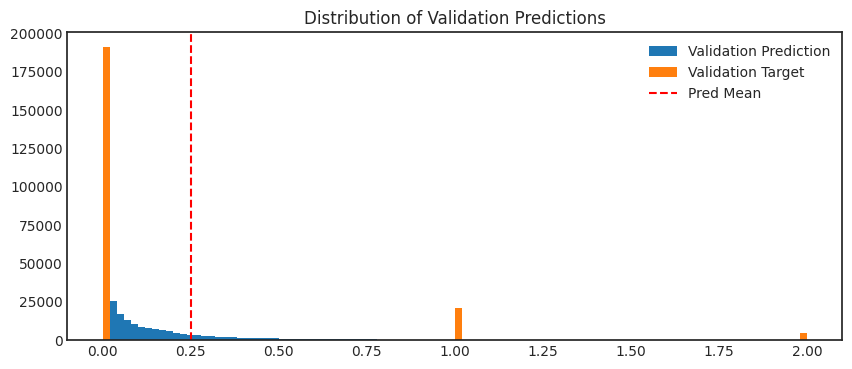

In [85]:
plt.figure(figsize=(10, 4))
plt.hist(val_preds, bins=100, range=(0, 2), label='Validation Prediction')
plt.hist(y_val, bins=100, range=(0, 2), label='Validation Target')
plt.axvline(x=val_preds.mean(), color='r', linestyle='--', label='Pred Mean')
plt.title("Distribution of Validation Predictions")
plt.legend()
plt.show()

## Residual

In [86]:
analysis_df = x_val.copy()
analysis_df['target'] = y_val
analysis_df['pred'] = val_preds
analysis_df['gap'] = analysis_df['target'] - analysis_df['pred']

cols_to_check = ['shop_id', 'item_id', 'item_category_id', 'item_cnt_month_lag_1', 'target', 'pred', 'gap', \
                 'item_age', 'item_shop_age',]

analysis_df.sort_values(by='gap', ascending=False)[cols_to_check].head(10)

,shop_id,item_id,item_category_id,item_cnt_month_lag_1,target,pred,gap,item_age,item_shop_age
8512399,40,17270,37,0,20,0.027761,19.972239,12,0
8512299,40,16629,37,0,20,0.035609,19.964392,11,0
8513395,40,21811,37,0,20,0.038335,19.961664,12,12
8510799,40,11055,37,0,20,0.054586,19.945414,12,5
8418171,12,20949,71,0,20,0.385464,19.614536,12,10
8519298,42,2431,24,0,20,0.441754,19.558247,10,10
8523630,42,20386,72,1,20,0.746525,19.253475,7,7
8521857,42,13241,47,0,20,0.999865,19.000135,0,0
8521862,42,13247,47,0,20,0.999865,19.000135,0,0
8479614,31,13247,47,0,20,1.231055,18.768944,0,0


In [87]:
analysis_df.sort_values(by='gap', ascending=True)[cols_to_check].head(10)

,shop_id,item_id,item_category_id,item_cnt_month_lag_1,target,pred,gap,item_age,item_shop_age
8414030,12,3759,20,0,0,15.303867,-15.303867,0,0
8412890,11,20949,71,20,3,18.180378,-15.180378,12,12
8414051,12,3849,20,0,0,13.827897,-13.827897,0,0
8519650,42,3759,20,0,0,13.600965,-13.600965,0,0
8413506,12,1586,20,0,2,15.155677,-13.155677,0,0
8413502,12,1581,20,0,2,15.155677,-13.155677,0,0
8461559,25,3759,20,0,0,13.004236,-13.004236,0,0
8461580,25,3849,20,0,0,12.235559,-12.235559,0,0
8413504,12,1583,20,0,3,15.155677,-12.155677,0,0
8519671,42,3849,20,0,0,12.145227,-12.145227,0,0


## feature importance

In [88]:
importance_dict = xgb_model.get_score(importance_type='total_gain')

feature_imp = pd.DataFrame(list(importance_dict.items()), columns=['feature', 'importance'])\
    .sort_values(by='importance', ascending=False).reset_index(drop=True)

feature_imp['normalized_importance'] = feature_imp['importance'] / feature_imp['importance'].sum()
feature_imp['cumulative_importance'] = feature_imp['normalized_importance'].cumsum()
feature_imp.tail(10)

,feature,importance,normalized_importance,cumulative_importance
21,item_shop_last_sale,1492113.250000,0.004404,0.976393
22,rolling_3m_price_mean,1412309.250000,0.004168,0.980561
23,platform,1067634.875000,0.003151,0.983712
24,delta_price_lag,1039816.937500,0.003069,0.986781
25,item_avg_date_sales_diff_2,1006643.937500,0.002971,0.989752
26,item_category_avg_date_sales_lag_1,991312.437500,0.002926,0.992678
27,category_nov_ratio,764363.187500,0.002256,0.994934
28,item_cnt_month_lag_2,755898.187500,0.002231,0.997164
29,transaction_cnt_lag_2,670154.375000,0.001978,0.999142
30,item_cnt_month_lag_3,290589.656250,0.000858,1.000000


/tmp/ipykernel_6048/1903301485.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')


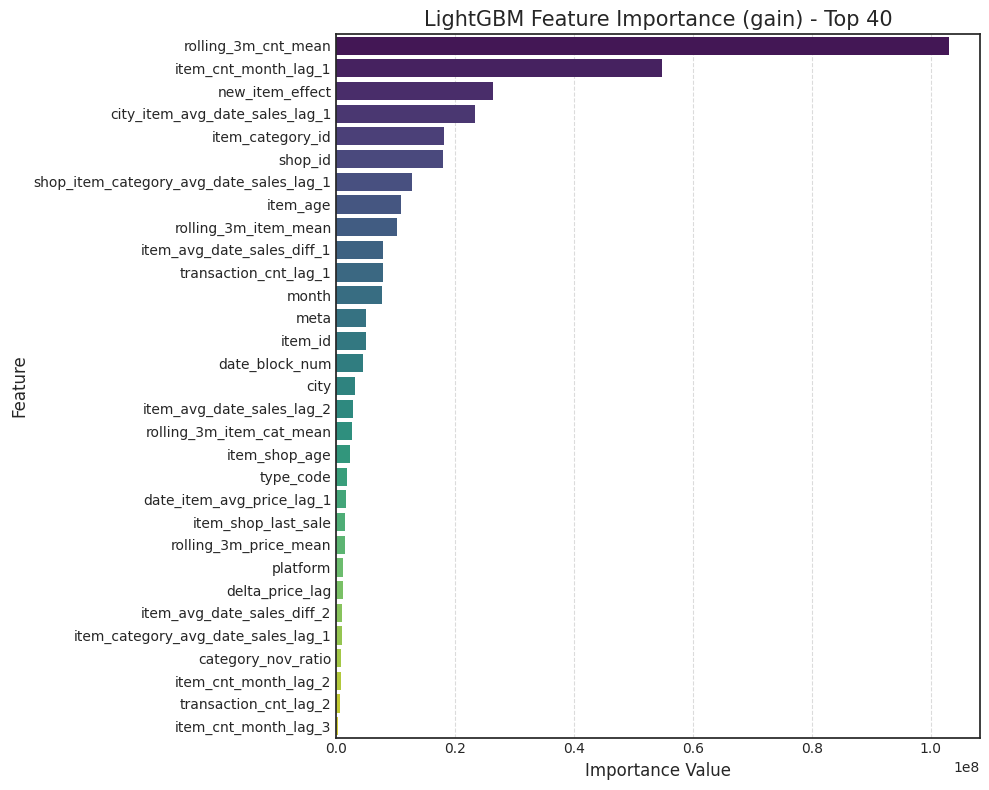

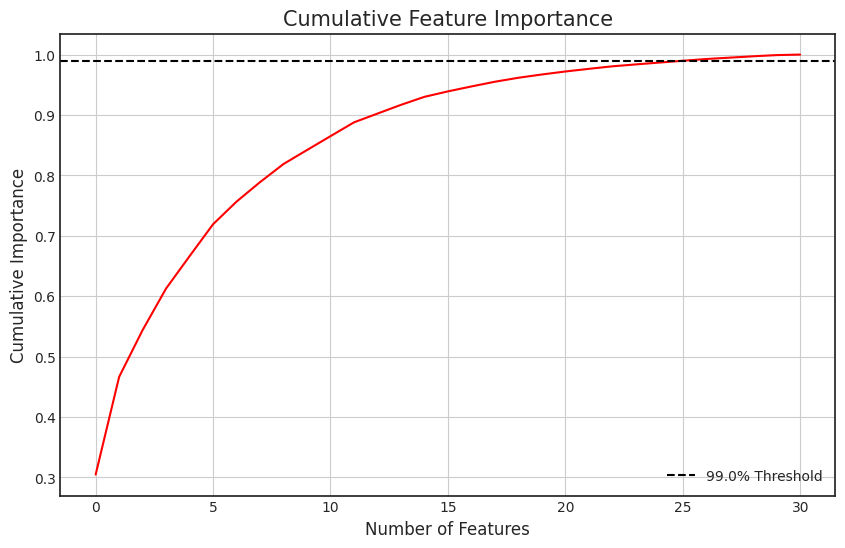

[GAIN] 분석 결과:
- 전체 피처 수: 31
- 99.0% 중요도를 설명하는 피처 수: 27
- 제거 추천 피처 수: 4
Low importance features :  ['category_nov_ratio', 'item_cnt_month_lag_2', 'transaction_cnt_lag_2', 'item_cnt_month_lag_3']


In [89]:
def analyze_and_filter_features(feature_imp, importance_type='gain', cum_threshold=0.99):
    plt.figure(figsize=(10, 8))    
    sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')
    plt.title(f'LightGBM Feature Importance ({importance_type}) - Top 40', fontsize=15)
    plt.xlabel('Importance Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_imp.index, feature_imp['cumulative_importance'], 'r-')
    plt.axhline(y=cum_threshold, color='k', linestyle='--', label=f'{cum_threshold*100}% Threshold')
    plt.title('Cumulative Feature Importance', fontsize=15)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    cutoff_index = feature_imp[feature_imp['cumulative_importance'] > cum_threshold].index[0]
    selected_features = feature_imp.loc[:cutoff_index, 'feature'].tolist()
    removed_features = feature_imp.loc[cutoff_index+1:, 'feature'].tolist()
    
    print(f"[{importance_type.upper()}] 분석 결과:")
    print(f"- 전체 피처 수: {len(feature_imp)}")
    print(f"- {cum_threshold*100}% 중요도를 설명하는 피처 수: {len(selected_features)}")
    print(f"- 제거 추천 피처 수: {len(removed_features)}")
    
    return feature_imp, removed_features

df_imp, del_cols = analyze_and_filter_features(feature_imp, importance_type='gain', cum_threshold=0.99)
print('Low importance features : ', del_cols)

# Prediction

In [90]:
xgb_test_preds = xgb_model.predict(dtest_xgb, iteration_range=(0, xgb_model.best_iteration + 1)).clip(0, 20)

In [91]:
# x_test는 all_data에서 왔으므로, 여기에 어떤 Shop ID가 들어있는지 확인하고 통일합니다.
df_pred = all_data.loc[all_data['date_block_num'] == 34, ['shop_id', 'item_id']].copy()
df_pred['item_cnt_month'] = xgb_test_preds

test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

submission = pd.merge(test, df_pred, on=['shop_id', 'item_id'], how='left')
submission[['ID', 'item_cnt_month']].to_csv('./data/submission_xgb_test.csv', index=False)

In [92]:
submission.head(10)

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.732189
1,1,5,5320,0.419323
2,2,5,5233,0.882359
3,3,5,5232,0.379091
4,4,5,5268,2.457878
5,5,5,5039,0.813199
6,6,5,5041,0.679751
7,7,5,5046,0.207210
8,8,5,5319,0.726197
9,9,5,5003,0.486241


# submission

In [98]:
lgbm_sub = pd.read_csv(data_path + 'submission_xgb.csv')
xgb_sub = pd.read_csv(data_path + 'submission_xgb_test.csv')

lgbm_sub.rename(columns={'item_cnt_month':'lgbm_preds'}, inplace=True)
xgb_sub.rename(columns={'item_cnt_month':'xgb_preds'}, inplace=True)

In [107]:
ensemble = pd.merge(lgbm_sub, xgb_sub, on='ID', how='left')
ensemble['item_cnt_month'] = ensemble['lgbm_preds'] * 0.9 + ensemble['xgb_preds'] * 0.1
ensemble.head()

,ID,lgbm_preds,xgb_preds,item_cnt_month
0,0,0.690470,0.732189,0.694642
1,1,0.434933,0.419323,0.433372
2,2,0.952510,0.882359,0.945495
3,3,0.354188,0.379091,0.356678
4,4,2.974874,2.457878,2.923174


In [108]:
ensemble[['lgbm_preds', 'xgb_preds']].corr()

,lgbm_preds,xgb_preds
lgbm_preds,1.000000,0.994896
xgb_preds,0.994896,1.000000


In [109]:
ensemble[['ID', 'item_cnt_month']].to_csv('./data/submission_ensemble.csv', index=False)
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submission_ensemble.csv" -m "ensemble"

100%|██████████████████████████████████████| 4.44M/4.44M [00:00<00:00, 13.0MB/s]
Successfully submitted to Predict Future Sales

In [97]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submission_xgb_test.csv" -m "submission_xgb"

100%|██████████████████████████████████████| 3.65M/3.65M [00:00<00:00, 11.6MB/s]
Successfully submitted to Predict Future Sales

In [113]:
lgbm_sub['item_cnt_month'] = lgbm_sub['lgbm_preds'] * 0.985
lgbm_sub[['ID', 'item_cnt_month']].to_csv('./data/submission_processing.csv', index=False)
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submission_processing.csv" -m "processing"

100%|██████████████████████████████████████| 4.52M/4.52M [00:00<00:00, 14.6MB/s]
Successfully submitted to Predict Future Sales